In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
dataset = pd.read_excel("data_col_sp.xlsx")
dataset.rename(columns = {"GDP, real, LCU":"PIB"}, inplace = True)
dataset = dataset.dropna() ## elimina missing
dataset['date']=pd.to_datetime(dataset['year'].astype(str) + 'Q' + dataset['quarter'].astype(str))
SerieTiempo = dataset.set_index('date')
SerieTiempo = SerieTiempo.sort_index()
SerieTiempo = SerieTiempo.asfreq('QS')

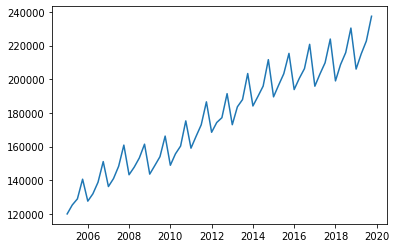

In [3]:
plt.plot(SerieTiempo['PIB'])

## Pre-procesamiento de los datos
Creación de los sets de entrenamiento y validación
Para el entrenamiento de la Red LSTM usaremos los datos entre 2005q1 y hasta 2016q4, mientras que para la validación y la predicción usaremos todos los registros a partir de 2017q1.



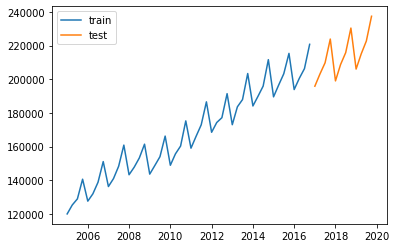

In [4]:
set_entrenamiento = SerieTiempo[:'2016'].iloc[:,11:12] # en donde .iloc[:,11:12] nos permite seleccionar únicamente la variable PIB.
set_validacion = SerieTiempo['2017':].iloc[:,11:12] 
fig, ax=plt.subplots()
plt.plot(set_entrenamiento, label='train')
plt.plot(set_validacion, label='test')
ax.legend();

## Normalización de los datos
Se usa la librería Scikit-learn para normalizar los valores en el rango de 0 a 1, usando la función:

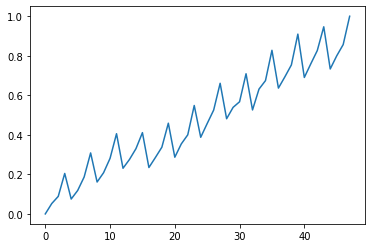

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
fig, ax=plt.subplots()
plt.plot()
plt.plot(set_entrenamiento_escalado)

In [6]:
len(set_entrenamiento_escalado)

48

## Ajuste de los sets de entrenamiento y validación


In [7]:
time_step = 1
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)

En el código anterior usamos el bloque for para iterativamente dividir el set de entrenamiento en bloques de datos y almacenar los bloques correspondientes en diferentes posiciones de las variables X_train y Y_train.

Antes de crear la Red LSTM debemos reajustar los sets que acabamos de obtener, para indicar que cada ejemplo de entrenamiento a la entrada del modelo será un vector. Para esto usamos la función reshape de Numpy:

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

Para el caso de cada una de las salidas (almacenadas en Y_train) debemos simplemente especificar que su tamaño será igual a 1, que corresponde al único valor predicho por la red.

## Creación y entrenamiento de la Red LSTM
Ahora sí procedemos a crear y entrenar nuestro modelo.

Implementación del modelo en Keras.
Para implementar el modelo debemos primero importar las librerías de Keras correspondientes a las Redes LSTM. Usaremos el módulo Sequential para crear el contenedor, al cual iremos añadiendo la Red LSTM (usando el módulo LSTM) y la capa de salida (usando el módulo Dense):

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

Para crear la red debemos primero definir el tamaño de los datos de entrada y del dato de salida, así como el número total de neuronas (100):

In [10]:
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 100

In [11]:
dim_entrada

(1, 1)

Como lo mencionamos anteriormente, para crear la Red LSTM debemos primero crear un contenedor usando el módulo Sequential:

In [12]:
modelo = Sequential()

1. Ahora añadimos la Red LSTM usando la función add, especificando el número de neuronas a usar (parámetro units) y el tamaño de cada dato de entrada (parámetro input_shape)

2. Para la capa de salida usamos la función Dense

3. Ahora debemos compilar el modelo, definiendo así la función de error (parámetro loss) así como el método que se usará para minimizarla (parámetro optimizer):

4. El optimizador seleccionado (rmsprop) funciona de manera similar al algoritmo del Gradiente Descendente, mientras que la función de error es el error cuadrático medio. El entrenamiento se implementa usando la función fit. En este caso utiliza un total de 150 iteraciones (parámetro epochs) y presentaremos a la Red LSTM lotes de 25 datos (parámetro batch_size):

In [13]:
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=150,batch_size=25)

Epoch 1/150
2/2 [==============================] - 2s 15ms/step - loss: 0.2868
Epoch 2/150
2/2 [==============================] - 0s 8ms/step - loss: 0.2564
Epoch 3/150
2/2 [==============================] - 0s 10ms/step - loss: 0.2361
Epoch 4/150
2/2 [==============================] - 0s 8ms/step - loss: 0.2193
Epoch 5/150
2/2 [==============================] - 0s 8ms/step - loss: 0.2044
Epoch 6/150
2/2 [==============================] - 0s 16ms/step - loss: 0.1908
Epoch 7/150
2/2 [==============================] - 0s 10ms/step - loss: 0.1782
Epoch 8/150
2/2 [==============================] - 0s 13ms/step - loss: 0.1666
Epoch 9/150
2/2 [==============================] - 0s 8ms/step - loss: 0.1555
Epoch 10/150
2/2 [==============================] - 0s 7ms/step - loss: 0.1449
Epoch 11/150
2/2 [==============================] - 0s 9ms/step - loss: 0.1349
Epoch 12/150
2/2 [==============================] - 0s 8ms/step - loss: 0.1254
Epoch 13/150
2/2 [==============================] - 0s 8

## Predicción
Con el modelo entrenado, veamos qué tan bien predice.

Inicialmente debemos preparar el set de validación, normalizando inicialmente los datos, en el rango de 0 a 1, para lo cual usamos la transformación implementada anteriormente sobre el set de entrenamiento:

In [14]:
x_test = set_validacion.values
x_test = sc.transform(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [15]:
X_test = []
for i in range(time_step,len(x_test)):
    X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

Y finalmente realizamos la predicción usando la función predict y aplicamos la normalización inversa de dicha predicción para que esté en la escala real:

In [16]:
prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
my_array = np.array(prediccion)
my_array
resultados = pd.DataFrame(my_array, columns = ['predict'])
resultados

,predict
0,195738.500000
1,202602.656250
2,209014.953125
3,222703.640625
4,198723.468750
5,208001.953125
6,214849.875000
7,229120.953125
8,205420.281250
9,214076.500000


In [17]:
# Fechas de pronóstico
Fechas = pd.date_range('2017q1', periods=11, freq='QS')
Fechas
# Configuración del índice 
# asignar los labes (linea anterior) de fecha a las predicciones
resultados.set_index(Fechas, inplace = True)
resultados

,predict
2017-01-01,195738.500000
2017-04-01,202602.656250
2017-07-01,209014.953125
2017-10-01,222703.640625
2018-01-01,198723.468750
2018-04-01,208001.953125
2018-07-01,214849.875000
2018-10-01,229120.953125
2019-01-01,205420.281250
2019-04-01,214076.500000


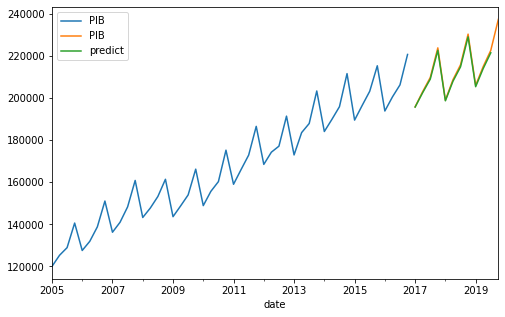

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
set_entrenamiento.plot(ax=ax, label='train')
set_validacion.plot(ax=ax, label='test')
resultados.plot(ax=ax, label='predictions')
ax.legend();

In [19]:
set_entrenamiento.rename(columns = {"PIB":"train"}, inplace = True)
set_validacion.rename(columns = {"PIB":"test"}, inplace = True)

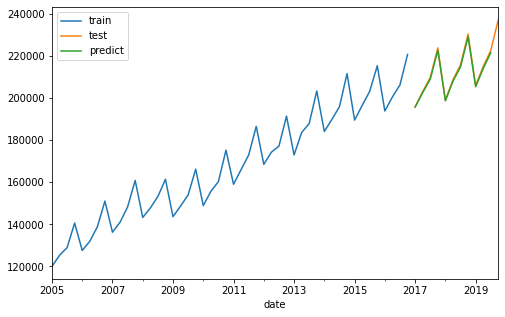

In [20]:
fig, ax = plt.subplots(figsize=(8, 5))
set_entrenamiento.plot(ax=ax, label='train')
set_validacion.plot(ax=ax, label='test')
resultados.plot(ax=ax, label='predictions')
ax.legend();